# **Talia Dhanampal**
# **RPDA Project**

## EDA

### Imports

In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from ipaddress import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score,auc,roc_curve,roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, Flatten, SpatialDropout1D, LSTM,Input, Concatenate, Reshape, InputLayer, concatenate
from tensorflow.keras.regularizers import l1, l2, l1_l2
import keras 

In [59]:
df = pd.read_csv('Android_Ransomeware.csv')
df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,172.217.2.174-10.42.0.211-443-51023-6,10.42.0.211,51023,172.217.2.174,443,6,16/06/2017 03:55:47,151054,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.2.174-10.42.0.211-443-51023-6,10.42.0.211,51023,172.217.2.174,443,6,16/06/2017 03:55:47,349,2,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.12.174-10.42.0.211-443-34259-6,10.42.0.211,34259,172.217.12.174,443,6,16/06/2017 03:55:52,119,2,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,3,172.217.10.74-10.42.0.211-443-55509-6,10.42.0.211,55509,172.217.10.74,443,6,16/06/2017 03:55:53,37055,1,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,4,172.217.2.174-10.42.0.211-443-44852-6,10.42.0.211,44852,172.217.2.174,443,6,16/06/2017 03:55:58,178727,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


Feature Extraction

In [60]:
df.columns = df.columns.str.strip()

In [61]:
import re
import ipaddress

# Extract 'Day of the Week' and 'Hour of the Day' from 'Timestamp'
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['HourOfDay'] = df['Timestamp'].dt.hour

# Packet Ratios
df['Fwd_Bwd_Pkt_Ratio'] = df['Total Fwd Packets'] / (df['Total Backward Packets'] + 1)
df['Fwd_Bwd_Len_Ratio'] = df['Total Length of Fwd Packets'] / (df['Total Length of Bwd Packets'] + 1)

# Port Categories
def port_category(port):
    if port <= 1023:
        return 'well_known'
    elif 1024 <= port <= 49151:
        return 'registered'
    else:
        return 'dynamic'

df['Src_Port_Category'] = df['Source Port'].apply(port_category)
df['Dst_Port_Category'] = df['Destination Port'].apply(port_category)

# Statistical Features of Packet Lengths
df['Pkt_Len_Var'] = df[['Fwd Packet Length Max', 'Bwd Packet Length Max']].var(axis=1)
df['Pkt_Len_Median'] = df[['Fwd Packet Length Max', 'Bwd Packet Length Max']].median(axis=1)

# Unique Byte/Packet Count Features (using entropy as an example)
def entropy(labels):
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log2(norm_counts)).sum()

df['Fwd_Entropy'] = df['Total Length of Fwd Packets'].apply(lambda x: entropy(list(str(int(x)))))

# Protocol-Specific Features
# Combine flag values
df['Flag_Combination'] = (
    df['FIN Flag Count'] + df['SYN Flag Count'] + df['RST Flag Count'] +
    df['PSH Flag Count'] + df['ACK Flag Count'] + df['URG Flag Count'] +
    df['CWE Flag Count'] + df['ECE Flag Count']
)

# IP Address Analysis
def is_private_ip(ip):
    try:
        return int(ipaddress.ip_address(ip).is_private)
    except ValueError:
        return 0

df['Source_IP_Private'] = df['Source IP'].apply(is_private_ip)
df['Destination_IP_Private'] = df['Destination IP'].apply(is_private_ip)

# Frequency-Based Features
df['Src_IP_Frequency'] = df.groupby('Source IP')['Source IP'].transform('count')
df['Dst_IP_Frequency'] = df.groupby('Destination IP')['Destination IP'].transform('count')

# Traffic Directionality
df['Is_Inbound'] = df.apply(lambda x: 1 if x['Source_IP_Private'] == 0 and x['Destination_IP_Private'] == 1 else 0, axis=1)

# Encode categorical features
label_encoder = LabelEncoder()
df['Src_Port_Category'] = label_encoder.fit_transform(df['Src_Port_Category'])
df['Dst_Port_Category'] = label_encoder.fit_transform(df['Dst_Port_Category'])
df['Protocol'] = label_encoder.fit_transform(df['Protocol'])

drop_columns = [
    'Flow ID', 'Source IP', 'Destination IP', 'Timestamp'
]
df = df.drop(columns=drop_columns)

C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_12024\415510543.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [62]:
df.head()

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,Dst_Port_Category,Pkt_Len_Var,Pkt_Len_Median,Fwd_Entropy,Flag_Combination,Source_IP_Private,Destination_IP_Private,Src_IP_Frequency,Dst_IP_Frequency,Is_Inbound
0,0,51023,443,1,151054,6,8,1076.0,4575.0,821.0,...,2,178204.5,1119.5,2.0,1,1,0,177977,344,0
1,1,51023,443,1,349,2,0,23.0,0.0,23.0,...,2,264.5,11.5,1.0,2,1,0,177977,344,0
2,2,34259,443,1,119,2,0,23.0,0.0,23.0,...,2,264.5,11.5,1.0,2,1,0,177977,882,0
3,3,55509,443,1,37055,1,1,31.0,0.0,31.0,...,2,480.5,15.5,1.0,2,1,0,177977,575,0
4,4,44852,443,1,178727,6,7,1313.0,307.0,753.0,...,2,171112.5,460.5,1.0,1,1,0,177977,344,0


### Cleaning

In [63]:
df.drop_duplicates()
df.dropna()

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,Dst_Port_Category,Pkt_Len_Var,Pkt_Len_Median,Fwd_Entropy,Flag_Combination,Source_IP_Private,Destination_IP_Private,Src_IP_Frequency,Dst_IP_Frequency,Is_Inbound
0,0,51023,443,1,151054,6,8,1076.0,4575.0,821.0,...,2,178204.5,1119.5,2.000000,1,1,0,177977,344,0
1,1,51023,443,1,349,2,0,23.0,0.0,23.0,...,2,264.5,11.5,1.000000,2,1,0,177977,344,0
2,2,34259,443,1,119,2,0,23.0,0.0,23.0,...,2,264.5,11.5,1.000000,2,1,0,177977,882,0
3,3,55509,443,1,37055,1,1,31.0,0.0,31.0,...,2,480.5,15.5,1.000000,2,1,0,177977,575,0
4,4,44852,443,1,178727,6,7,1313.0,307.0,753.0,...,2,171112.5,460.5,1.000000,1,1,0,177977,344,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392029,2927,53849,53,2,24707,1,1,48.0,199.0,48.0,...,2,11400.5,123.5,1.000000,0,1,1,115388,73665,0
392030,2928,34559,123,2,81388,1,1,48.0,48.0,48.0,...,2,0.0,48.0,1.000000,0,1,0,115388,5,0
392031,2929,23177,53,2,61591,1,1,39.0,98.0,39.0,...,2,1740.5,68.5,1.000000,0,1,1,115388,73665,0
392032,2930,30407,53,2,24831,1,1,36.0,153.0,36.0,...,2,6844.5,94.5,1.000000,0,1,1,115388,73665,0


In [64]:
df = df.dropna()

In [65]:
df.isna().sum(axis=0)

Unnamed: 0                0
Source Port               0
Destination Port          0
Protocol                  0
Flow Duration             0
                         ..
Source_IP_Private         0
Destination_IP_Private    0
Src_IP_Frequency          0
Dst_IP_Frequency          0
Is_Inbound                0
Length: 97, dtype: int64

Converting categorical columns to numerical where necessary.
Label encoding the 'Label' column to make it suitable for models.


In [66]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

Encoding categorical variables if necessary.


In [67]:
if df['Protocol'].dtype == 'object':
 df['Protocol'] = label_encoder.fit_transform(df['Protocol'])

Visualisation

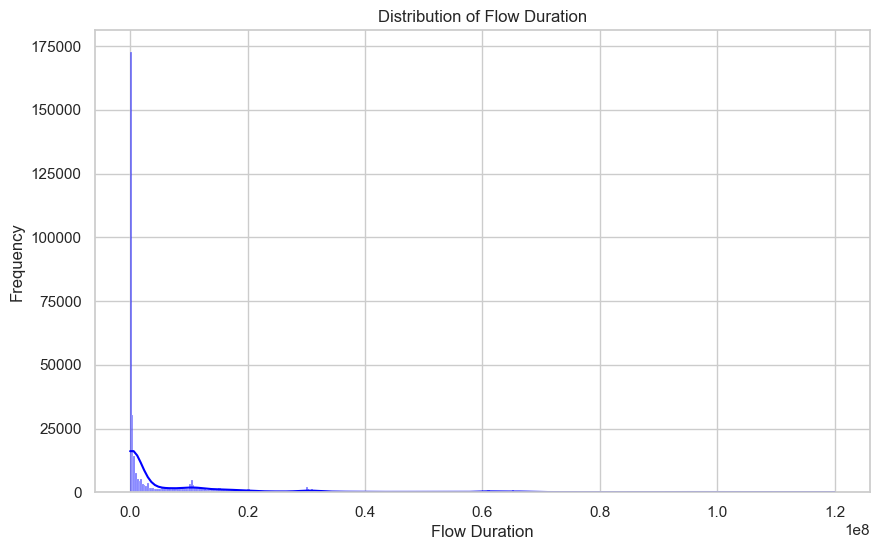

In [69]:
sns.set(style="whitegrid")

# Plot 1: Distribution of Flow Duration
plt.figure(figsize=(10, 6))
sns.histplot(df['Flow Duration'], kde=True, color='blue')
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.show()

C:\Users\lab_services_student\AppData\Local\Temp\ipykernel_12024\466354629.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Protocol', data=df, palette='viridis')


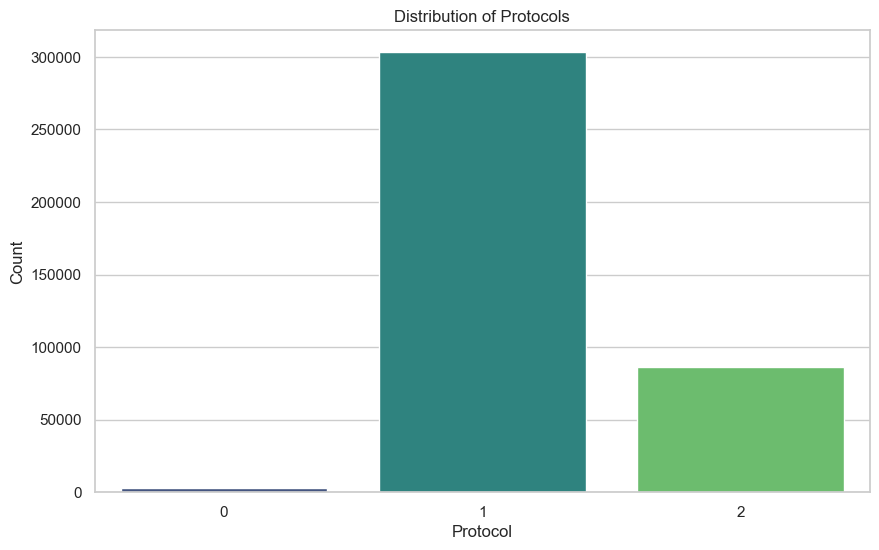

In [72]:
# Plot 3: Distribution of Protocols
plt.figure(figsize=(10, 6))
sns.countplot(x='Protocol', data=df, palette='viridis')
plt.title('Distribution of Protocols')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

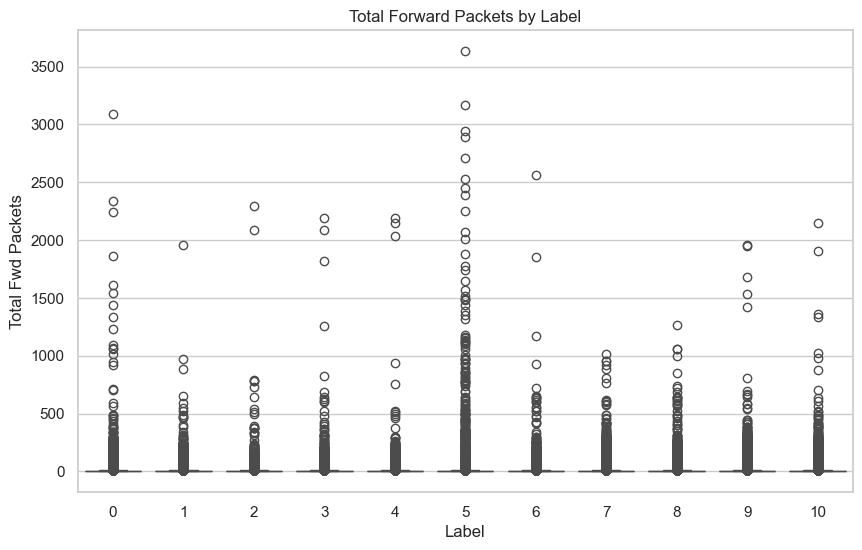

In [74]:
# Plot 4: Boxplot for Total Fwd Packets vs Label
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Total Fwd Packets', data=df)
plt.title('Total Forward Packets by Label')
plt.xlabel('Label')
plt.ylabel('Total Fwd Packets')
plt.show()

In [78]:
df.to_csv('cleaned_df.csv', index=False)